# NMO correction

The traveltime as a function of offset of a reflected event can be
approximated by the NMO traveltime:

\$ (t_0,h) = \$

where $(t_0)$ is the zero-offset or vertical traveltime and $v$ is the
effective or NMO velocity.

We can now correct the data for the moveout via a simple coordinate
transform:

\$ d\_{NMO}(t_0,h) = d((t_0,h),h) \$

You can use the function `nmo` implemented below for this exercise.

Please download data from Dropbox:
https://www.dropbox.com/scl/fi/yu3r82yhxs4tf3znky0wi/cube2.segy?rlkey=um2e51u461y0e4239mhxyz09k&st=fww1y5l5&dl=0
Password is exact same with the password which you used to access the
lecture note.

In [1]:
using Pkg
Pkg.add("Dierckx")
using Dierckx
function nmo(cmp, t, off, v)
# NMO correction and adjoint 
#
# use:
#   out = nmo(in,t,h,v,flag)
#
# input:
#   in   - data matrix of size [length(t) x length(h)], each column is a trace 
#   t    - time vector [s]
#   offsets    - offset vector [m]
#   v    - NMO velocity [m/s] as vector of size [length(t) x 1].
#   flag - 1:forward, -1:adjoint
#
# output
#   out  - data matrix of size [length(t) x length(h)], each column is a trace 
    if size(cmp, 2) == 1
        return cmp
    end
    # size of data
    nt, nh = size(cmp)
    # make sure t and v are column vectors
    t = t[:]
    v = v[:]
    # initialize output
    out = zeros(nt, nh)
    # loop over offset
    for i = 1:nh
        # NMO traveltime
        tau = sqrt.(t.^2 + off[i].^2 ./v.^2);
        # interpolate, forward or adjoint
        spl = Spline1D(t, cmp[1e-3*T.-t.<1e-5, i])
        out[:,i] = spl(tau)
    end
    return out
end

nmo (generic function with 1 method)

In [2]:
using SegyIO, PyPlot

In [3]:
# read the dataset

blocks = segy_read("/home/yzhang3198/Downloads/data_segy/cube2.segy");

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=90663444, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/yzhang3198/.julia/packages/SegyIO/ak2qG/src/read/read_file.jl:26

In [4]:
sx = get_header(blocks, "SourceX";scale=false)
rx = get_header(blocks, "GroupX";scale=false);


In [5]:
# Get the time axis. In this case the time axis is the same for all traces so we only need to extract it from the first trace
# dt needs to be corrected for the binary setup
# All the times are in ms
dt = get_header(blocks, "dt")[1]/1000
nt = get_header(blocks, "ns")[1]
T = 0:dt:(nt-1)*dt

0.0:4.0:2000.0

In [6]:
# Midpoint and offset
h = (sx .- rx);
m = (sx .+ rx)./2;

In [7]:
all_m = hcat(m'...)'
fold = [sum(all_m .== unique(all_m)[i]) for i=1:length(unique(all_m))];

all_h = hcat(h'...)';

# Pick a midpoint

In [8]:
Im = findall(all_m .== all_m[1000])
offsets = sort((all_h[Im]));
inds = sortperm(all_h[Im])
cmp = Float32.(blocks.data[:, Im[inds]]);

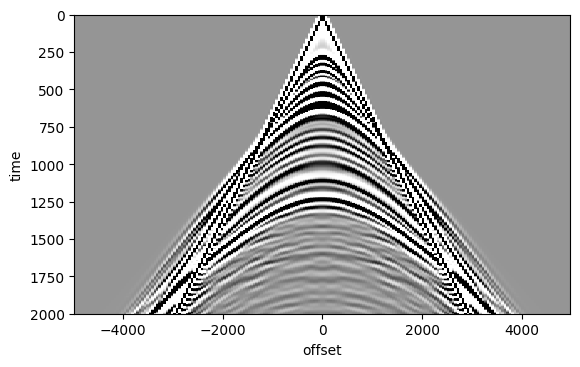

PyObject Text(24.0, 0.5, 'time')

In [9]:
figure()
imshow(cmp, vmin=-1, vmax=1, cmap="Greys", aspect=3, extent=[offsets[1], offsets[end], T[end], 0])
xlabel("offset")
ylabel("time")

# Constant velocity NMO correction

In [10]:
nmo_corrected1 = nmo(cmp, 1e-3.*T, offsets, 2000 .+ 0 .*T);

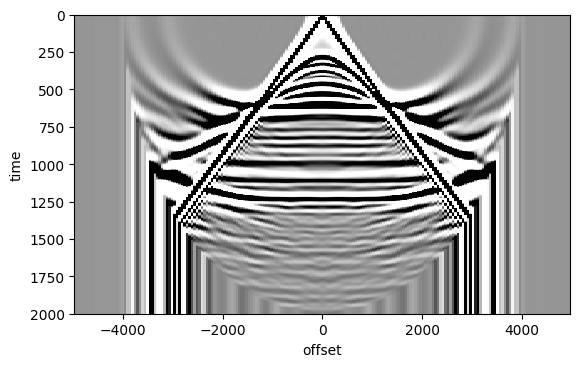

PyObject Text(24.0, 0.5, 'time')

In [11]:
figure()
imshow(nmo_corrected1, vmin=-1, vmax=1, cmap="Greys", aspect=3, extent=[offsets[1], offsets[end], T[end], 0])
xlabel("offset")
ylabel("time")

# Windowing

We can see a lot of \`artifacts’ in the NMO corrected gather above. To
avoid some of the artifacts, the midpoint gathers are often windowed to
select reflected data only. All events that arrive before the direct
wave are removed. A typical window looks like this (Hint: the slope of
the triangle is related to the veloctity of the direct wave).

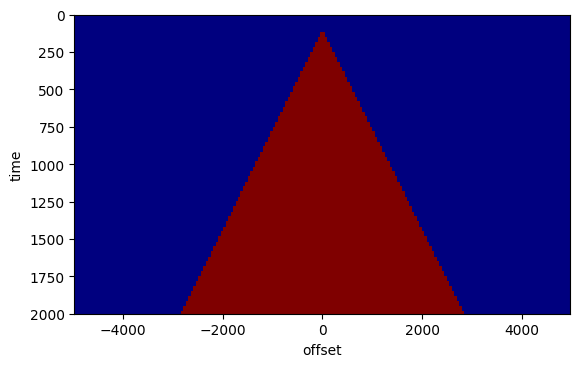

PyObject Text(24.0, 0.5, 'time')

In [14]:
# grid
tt = [1e-3*ti for ti in T for h in offsets]
hh = [h for ti in T for h in offsets]

# initialize window to zero and set times later than first arrival to 1.
W=0 .*tt;W[tt .> (.1 .+ abs.(hh)./1500)] .= 1
W = reshape(W, size(cmp)[2], size(cmp)[1])
imshow(W', vmin=0, vmax=1, cmap="jet", aspect=3, extent=[offsets[1], offsets[end], T[end], 0])
xlabel("offset")
ylabel("time")


In [15]:
muted = W'.*cmp;

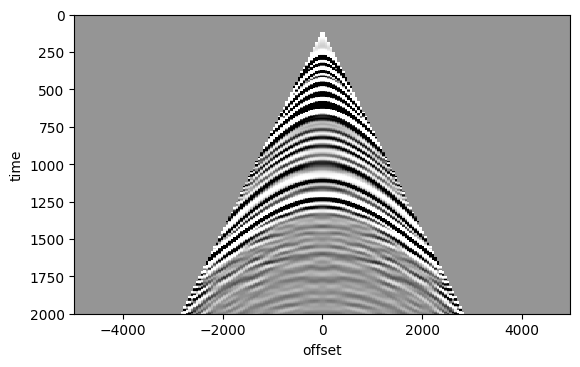

PyObject Text(24.0, 0.5, 'time')

In [16]:
figure()
imshow(muted, vmin=-1e0, vmax=1e0, cmap="Greys", aspect=3, extent=[offsets[1], offsets[end], T[end], 0])
xlabel("offset")
ylabel("time")

# Stack power

To figure out which NMO velocity optimally flattens all the events, we
can scan through a range of constant NMO velocities and see which events
are flattened for which velocity. One way to judge flatness of an event
is via the stackpower. The stackpower is just a sum along the offset
direction of the values-squared of the NMO-corrected gather:

\$ S(t_0,v) = !!h, d((t_0,h,v),h)^2 \$

The function \$ S(t_0,v) \$ is called a semblance panel.

The desired NMO velocity can be found by picking the maximum as a
function of $t_0$ and $v$ from the semblance panel.

An example of a semblance panel and the resulting NMO velocity is shown
below.

In [17]:
v = 1000:(3000-1000)/(500-1):3000
# scan over velocities
S = zeros(length(T),length(v));
for k = 1:length(v)
    cmp_nmo = nmo(muted, 1e-3.*T, offsets, v[k] .+ 0 .*T);
    S[:,k]  = sum(cmp_nmo .^2, dims = 2);
end

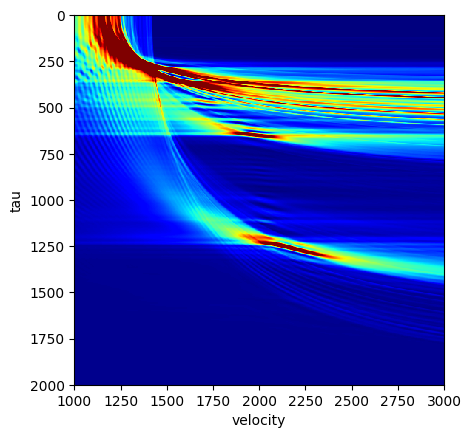

PyObject Text(24.0, 0.5, 'tau')

In [18]:
#Plot semblance panel
figure()
imshow(S, vmin=0, vmax=1e3, cmap="jet", aspect=1, extent=[v[1], v[end], T[end], 0])
xlabel("velocity")
ylabel("tau")

In [ ]:
#  pick v/tau pairs

In [19]:
tv   = 1e3*[0,    0.30, 0.35, 0.46, 0.65, 1.27, 2.00];
vnmo =     [1500, 1500, 1600, 1700, 2000, 2179, 3000];
spl = Spline1D(tv, vnmo; k=1)
vnmo_all = spl(T);

# Look at the velocity profile with the picked tau/v pairs

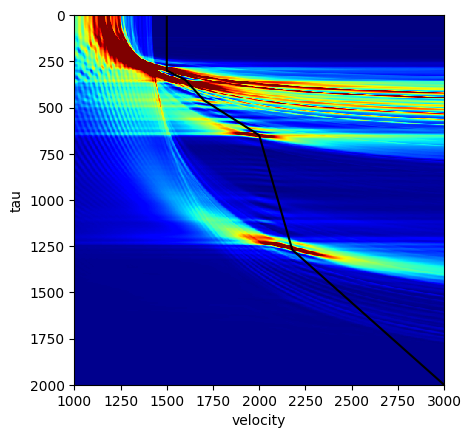

PyObject Text(24.0, 0.5, 'tau')

In [20]:
# Enable gui to have the cursor and pick v/tau pairs
figure()
imshow(S, vmin=0, vmax=1e3, cmap="jet", aspect=1, extent=[v[1], v[end], T[end], 0])
plot(vnmo_all, T, "-k")
xlabel("velocity")
ylabel("tau")

In [21]:
nmo_corrected = nmo(muted, 1e-3.*T, offsets, vnmo_all) ;

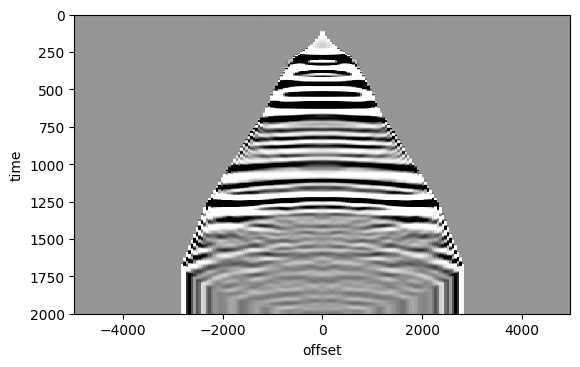

PyObject Text(24.0, 0.5, 'time')

In [22]:
figure()
imshow(nmo_corrected, vmin=-1e0, vmax=1e0, cmap="Greys", aspect=3, extent=[offsets[1], offsets[end], T[end], 0])
xlabel("offset")
ylabel("time")

# Velocity analysis

Repeat the above outline procedure for a couple of mipdoint positions xm
(e.g., `xm = [500 1000 2000]`). Organize the resulting NMO velocities in
a matrix `Vm` (where column i is the NMO velocity for midpoint `xm[i]`)
interpolate the results to obtain a velocity for all the midpoints using
`Spline1D(xm, VM); spl(all_m)`. Plot the velocity and discuss.

Using this NMO velocity, we can produce an NMO stack. Perform an NMO
correction of all the midpoint gathers using the corresponding NMO
velocity derived above and sum each along the offset direction. Organize
all the stacks in a matrix and plot the result. Also make a stack using
a constant NMO velocity. Discuss the results.